# Handwritten Digits - MNIST GAN First Attempt

Make Your First GAN With MindSpore, 2022

In [1]:
# import libraries

import mindspore
import mindspore.nn as nn

import pandas, numpy, random
import matplotlib.pyplot as plt

## Dataset Class

In [2]:
# dataset class

class MnistDataset:
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        target = numpy.zeros((10), dtype=numpy.float32)
        target[label] = 1.0
        
        # image data, normalised from 0-255 to 0-1
        image_values = numpy.array(self.data_df.iloc[index,1:].values, dtype=numpy.float32) / 255.0
        
        # return label, image data tensor and target tensor
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')


In [3]:
# load data

mnist_dataset = MnistDataset('./dataset/mnist/mnist_train.csv')

train_dataset = mindspore.dataset.GeneratorDataset(mnist_dataset, ['label', 'image', 'target']).batch(1)

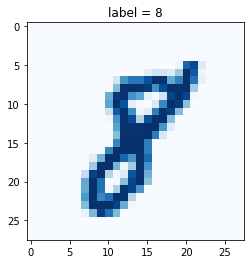

In [4]:
# check data contains images

mnist_dataset.plot_image(17)

## Data Functions

In [5]:
# function to generate uniform random data

def generate_random(*size):
    random_data = mindspore.Tensor(numpy.random.rand(*size), mindspore.float32)
    return random_data

In [6]:
generate_random(1, 4)

Tensor(shape=[1, 4], dtype=Float32, value=
[[ 1.20920599e-01,  9.86414671e-01,  3.55685174e-01,  1.38160661e-01]])

## Discriminator Network

In [7]:
# discriminator class

class Discriminator(nn.Cell):
    
    def __init__(self):
        # initialise parent cell class
        super().__init__()
        
        # define neural network layers
        self.model = nn.SequentialCell(
            nn.Dense(784, 200),
            nn.Sigmoid(),
            nn.Dense(200, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.MSELoss()

        # create optimizer, simple stochastic gradient descent
        self.optimizer = nn.SGD(self.trainable_params(), learning_rate=0.01)
        
        self.model_with_loss = nn.WithLossCell(self.model, self.loss_function)
        self.model_train = nn.TrainOneStepCell(self.model_with_loss, self.optimizer)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
    
    def construct(self, inputs):
        if inputs.ndim == 1:
            inputs = mindspore.ops.ExpandDims()(inputs, 0)
            return self.model(inputs).squeeze(0)
        else:    
            return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # train one step
        loss = self.model_train(inputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.asnumpy().item())
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))


## Test Discriminator

In [8]:
%%time
# test discriminator can separate real data from random noise

D = Discriminator()

for label, image_data_tensor, target_tensor in train_dataset:
    # real data
    D.train(image_data_tensor, mindspore.Tensor([[1.0]], mindspore.float32))
    # fake data
    D.train(generate_random(1, 784), mindspore.Tensor([[0.0]], mindspore.float32))


counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 5min 58s, sys: 1min 38s, total: 7min 36s
Wall time: 5min 29s


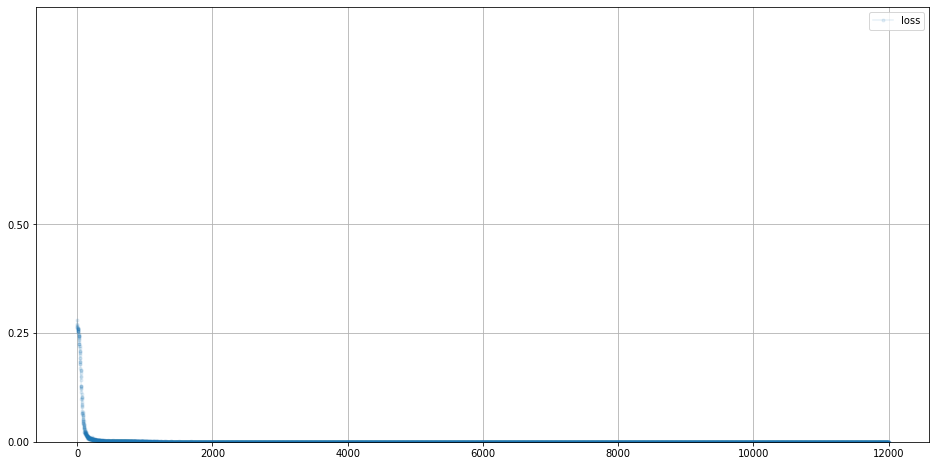

In [9]:
# plot discriminator loss

D.plot_progress()

In [10]:
# manually run discriminator to check it can tell real data from fake

for i in range(4):
  image_data_tensor = mindspore.Tensor(mnist_dataset[random.randint(0,60000)][1], mindspore.float32)
  print( D.construct( image_data_tensor ).asnumpy().item() )

for i in range(4):
  print( D.construct( generate_random(784) ).asnumpy().item() )


0.9953887462615967
0.9961572289466858
0.9882338047027588
0.9952635765075684
0.004888670984655619
0.004821850918233395
0.003960633184760809
0.004390086978673935


## Generator Network

In [11]:
# generator class

class Generator(nn.Cell):
    
    def __init__(self, D_with_loss):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.SequentialCell(
            nn.Dense(1, 200),
            nn.Sigmoid(),
            nn.Dense(200, 784),
            nn.Sigmoid()
        )
        
        self.loss_fn = D_with_loss
        
        # create optimizer, simple stochastic gradient descent
        self.optimizer = nn.SGD(self.trainable_params(), learning_rate=0.01)
        
        self.model_train = mindspore.build_train_network(self.model, self.optimizer, loss_fn=self.loss_fn)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

    def construct(self, inputs):        
        # simply run model
        if inputs.ndim == 1:
            inputs = mindspore.ops.ExpandDims()(inputs, 0)
            return self.model(inputs).squeeze(0)
        else:    
            return self.model(inputs)
    
    def train(self, inputs, targets):
        # calculate error
        loss = self.model_train(inputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.asnumpy().item())

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))


## Test Generator Output

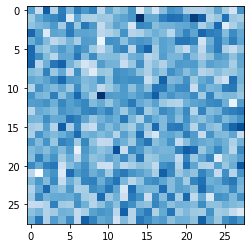

In [12]:
# check the generator output is of the right type and shape

G = Generator(D.model_with_loss)

output = G.construct(generate_random(1))

img = output.asnumpy().reshape(28,28)

plt.imshow(img, interpolation='none', cmap='Blues')

## Train GAN

In [13]:
%%time 

# create Discriminator and Generator

D = Discriminator()
G = Generator(D.model_with_loss)

label_true = mindspore.Tensor([[1.0]], mindspore.float32)
label_false = mindspore.Tensor([[0.0]], mindspore.float32)

# train Discriminator and Generator
for label, image_data_tensor, target_tensor in train_dataset:

    # train discriminator on true
    D.train(image_data_tensor, label_true)
    
    # train discriminator on false
    D.train(G.construct(generate_random(1, 1)), label_false)
    
    # train generator
    G.train(generate_random(1, 1), label_true)


counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 5min 31s, sys: 2min 13s, total: 7min 44s
Wall time: 4min 56s


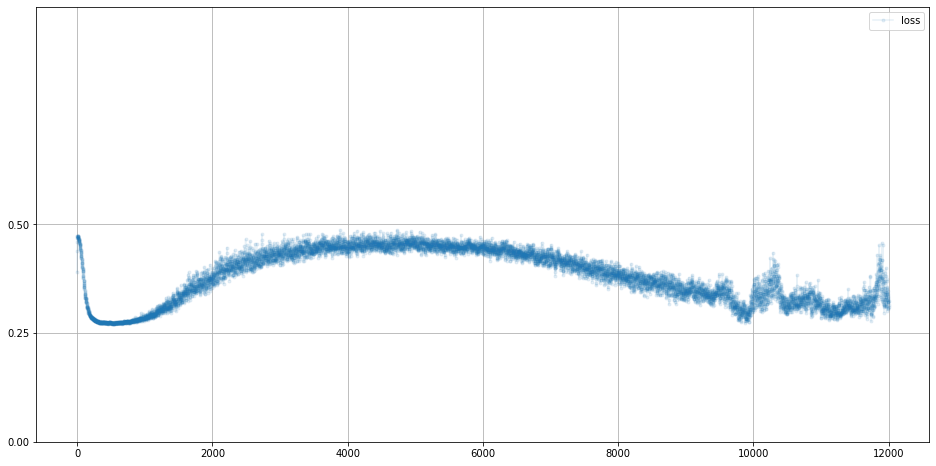

In [14]:
# plot discriminator error

D.plot_progress()

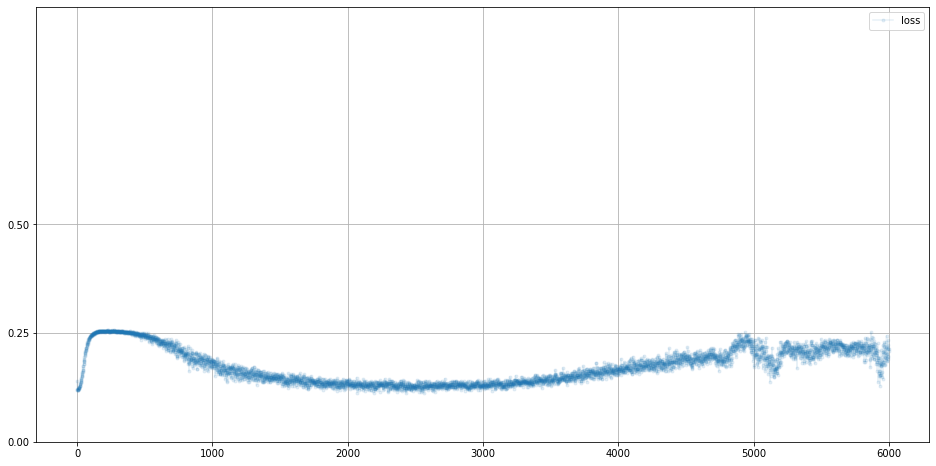

In [15]:
# plot generator error

G.plot_progress()

## Run Generator

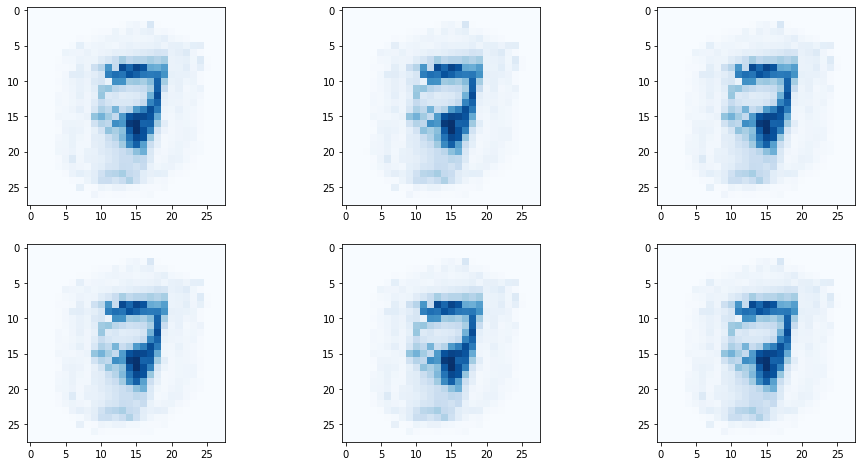

In [16]:
# plot several outputs from the trained generator

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.construct(generate_random(1))
        img = output.asnumpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
